# CNNs en Google Street View

En este problema, se trabajará con el dataset de imágenes de dígitos de direcciones de Google Street View, llamado SVHN (Street View House Numbers). El dataset en total posee 600 mil imágenes, las que son divididas en 3 archivos, 2 de los  cuales fueron usados para la mayoría de las secciones. Y utilizando el tercero, el que posee la mayor cantidad de dígitos (el archivo extra), para observar si es que existe un mejor resultado al utilizar un dataset mayor.

Por lo que en resumen, los tres archivos correspondientes son:
train_32x32.mat Imágenes de entrenamiento, que corresponden a 73.257 del total.
extra_32x32.mat Imágenes "Extras", que corresponden a casi el total de imágenes de entrenamiento (526.743 en total)
test_32x32.mat Imágnes de Prueba, que son 26.032.

Se cargan las librerías a utilizar.

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline
import warnings
import keras
import matplotlib

Using TensorFlow backend.



Posteriormente son cargados los datos desde los archivos .mat, luego se realizan las transformaciones necesarias para obtener las matrices a utilizar. 
Se setean todos sus valores a formato float32, y se analiza la cantidad de clases que posee el problema.

In [2]:
train_data = sio.loadmat('data/train_32x32.mat')
test_data = sio.loadmat('data/test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))
print 'número de clases: ',n_classes

número de clases:  10


Del cual se obtiene que el número total de clases, corresponde a 10, esto dado que se trata de un dataset de digitos, con lo que sus valores fluctuarán entre 0 y 9.

Se procede a observar el tipo de datos, de manera visual, por lo que se obtienen imágenes de forma aleatoria (Manualmente), para posteriormente guardarlas.

In [5]:
# Guardando imágenes.
import matplotlib.image as mpimg
import scipy.misc

print y_train[500]
x = np.transpose(X_train[500], (1, 2, 0))
scipy.misc.imsave('Imagen1.png', x)

print y_test[500]
x = np.transpose(X_test[500], (1, 2, 0))
scipy.misc.imsave('Imagen2.png', x)


[2]


IOError: encoder zip not available

A continuación se presentan las imágenes obtenidas, tanto como de los datos de entrenamiento como de los de prueba.

Es necesario recordar, que el número de clases diferentes es 10, y que los valores van desde el 0 al 9 en las imágenes, pero su etiquetación corresponde un 9 cuando el dígito es un 0, un 8 cuando es un 7 y así sucesivamente hasta llegar al 1 que es correspondido por un 0.

Imágenes de Entrenamiento
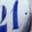 
[0] Se aprecia un 1 bastante claro, pero acompañado de un trozo de otro número.
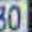 
[9] Un cero bastante claro, pero también acompañado de un trozo de otro número.
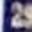 
[1] Un dos muy difuso, y con gran parte de otro número, lo que puede afectar enormemente en la red.
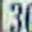 
[2] Un número 3, que se encuentra cortado en la parte de abajo.
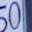 
[9] Un 0.

Imágenes de Prueba
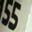 
[4] Un número 5, acompañado por otro de igual valor, el cual es posible apreciar casi completamente.
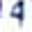 
[3] Un 4 muy difuso.
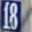 
[7] Acá se puede apreciar dos números bastante claro, un 1 y un 8, pero es considerado como 8 en su etiquetación. Aún así puede afectar cuando sea utilizado, en la forma que aprende la red.
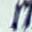 
[0] Una imagen muy poco clara,donde es posible observar un 1 y un 7.
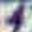 
[3] un número 4 poco claro.

Después de analizar las imágenes, es posible apreciar que, si bien, se encuentran bien etiquetadas cada una de ellas, es decir, que el valor corresponde a lo que se puede observar. Se logra concluir que el dataset utilizado no se encuentra muy bien filtrado, esto, en cuanto a la cantidad de dígitos que son mostrados por archivo.

Si bien una red entrenada debería ser capaz de distinguir cada uno de los valores separadamente, esto no quiere decir que sea beneficioso entrenar la red con datos que no se encuentran bien filtrados.

#### Normalización de Datos.

Los datos son posteriormente normalizados, cada uno de sus pixeles son divididos por 255 para obtener un valor entre 0 y 1. Y posteriormente la matrices objetivos, son llevadas a un hot vector , vector que es llenado de 0 salvo en el lugar donde será representada dicha clase, la cual tendrá el valor de 1, lo que permite un entrenamiento de red más optimo.


In [3]:
#PARTE B
from keras.utils import np_utils
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

#### Red CNN C × P × C × P × F × F

Se define a continuación una red CNN con arquitectura C × P × C × P × F × F, es decir con dos capas convolucionales y dos de Max Pooling (una detrás de otra), seguida por dos feedforward, donde la última posee 10 neuronas de salidas, dado el tipo de problema.
La primera capa convolucional utiliza 16 filtros de 5x5, y la segunda 512 de 7x7.

Según el enunciado, una red similar a la implementada a continuación alcanza casi un 95% de accuracy, por lo que esta, debería andar cercano a dicho valor.

Dentro de la función MaxPooling2D , se utiliza el data_format = "channels_first" dado que se utiliza Tensorflow como backend.

Y el optimizador utilizado es Adagrad con un learning rate de 0.01. En esta parte sólo se utilizaron 12 epochs.


In [4]:
#PARTE C
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad

model = Sequential()
model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Conv2D(512, (7, 7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()
adagrad = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])
hist = model.fit(X_train, Y_train, batch_size=1280, epochs=12, verbose=1, validation_data=(X_test, Y_test))



#Se evalua el modelo sobre el conjunto de validacion
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 32, 16)         12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 16, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 16, 512)        201216    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 8, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                122900    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total para

Los valores finales al testear la red con los datos de prueba:
('Test loss:', 1.3054544072101362)
('Test accuracy:', 0.58612476951444381)

Y los gráficos de accuracy y loss por epochs fueron los siguientes.
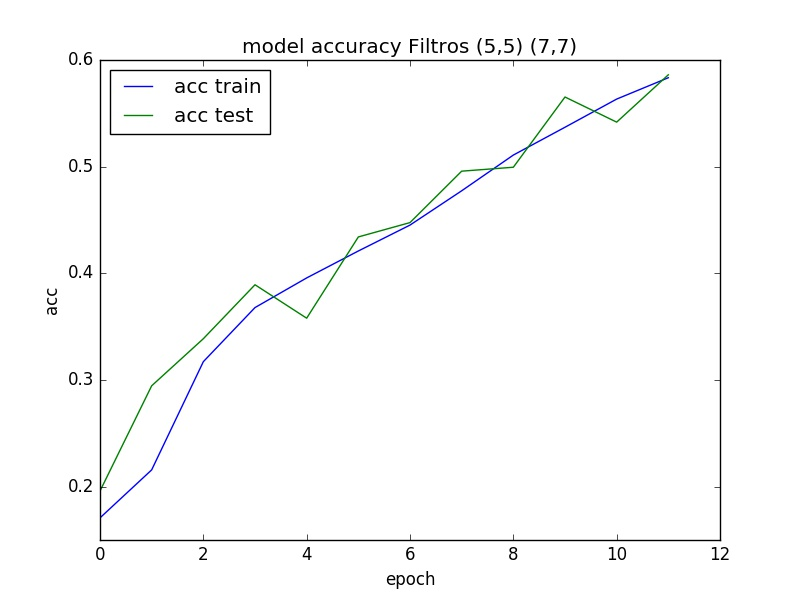
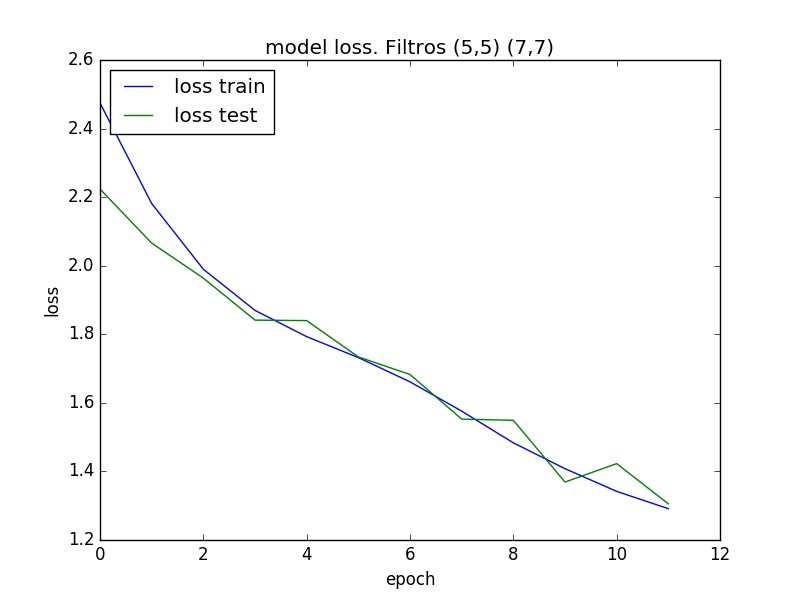

Es posible observar que, a pesar de que se entrenó la red con una cantidad pequeña de epochs, el porcentaje de asertividad que obtuvo la red fue de alrededor del 60% y un error de prueba del 1.3. Al mirar sólo el gráfico de Accuracy se logra apreciar que la pendiente que aún tenía la gráfica era bastante pronunciada, lo que indica que aún se encontraba en un proceso de aprendizaje y que quizás con una mayor cantidad de epochs, mejor sería su desempeño.

#### Red CNN modificando tamaño de filtros

A continuación se estudia el comportamiento que posee una red al modificar el tamaño de sus filtros. 
Para ello se realizaron 3 pruebas distintas, una con filtros de menor tamaño y otros dos con mayores tamaños que la red utilizada anteriormente.

En primer lugar se analiza el resultado de una red, disminuyendo sus filtros en ambas capas, seteandolos en 3x3 en la primera y de 5x5 en la segunda.

In [5]:
#Parte D CON MENOR
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Conv2D(512, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()
adagrad = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])
hist = model.fit(X_train, Y_train, batch_size=1280, epochs=12, verbose=1, validation_data=(X_test, Y_test))



#Se evalua el modelo sobre el conjunto de validacion
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 3, 32, 16)         4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 16, 8)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 16, 512)        102912    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 8, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                122900    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total para

El resultado de la red al utilizar filtros de menor tamaño, producen una mejor respuesta que la red entrenada anteriormente, esto se refleja ya que al 12avo epoch, su porcentaje de asertividad se ve cercano al 70% y con un error de aproximadamente 1.2 para ambos tipos de datos, ya sea para entrenamiento, como para los de prueba.


Gráficos de Accuracy vs Epoch, y Loss vs Epoch.
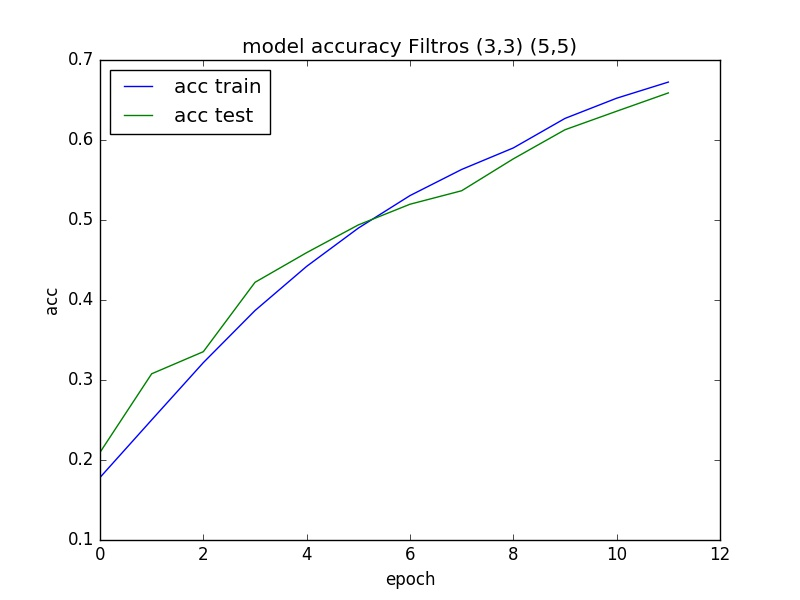
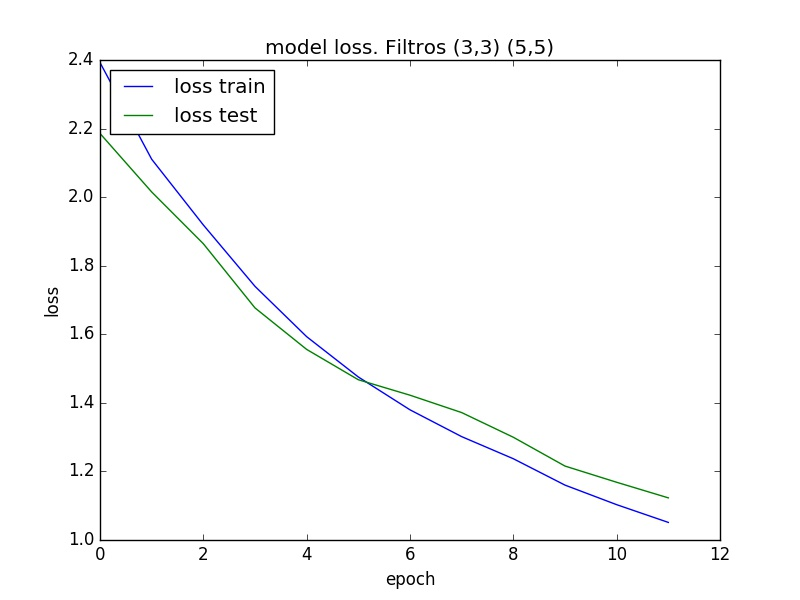

A continuación se estudiará el uso de filtros de mayor tamaño, pero ahora no tan sólo cambiando los de las capas convolucionales si no que también los de las capas de Pooling.

In [6]:
#Parte D MAYOR
model = Sequential()
model.add(Conv2D(16, (7, 7), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(4, 4), data_format="channels_first"))
model.add(Conv2D(512, (9, 9), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), data_format="channels_first"))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()
adagrad = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])
hist = model.fit(X_train, Y_train, batch_size=1280, epochs=12, verbose=1, validation_data=(X_test, Y_test))



#Se evalua el modelo sobre el conjunto de validacion
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 3, 32, 16)         25104     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 8, 4)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 8, 512)         166400    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 2, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                15380     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
Total para

Los resultados obtenidos, al aumentar las dimensiones de los filtros, no son mejores que al disminuirlos, es más, el porcentaje de accuracy final, al evaluarlos en los datos de test, es casi un 30% más bajo.

A continuación pueden observarse los resultados obtenidos por cada epoch.

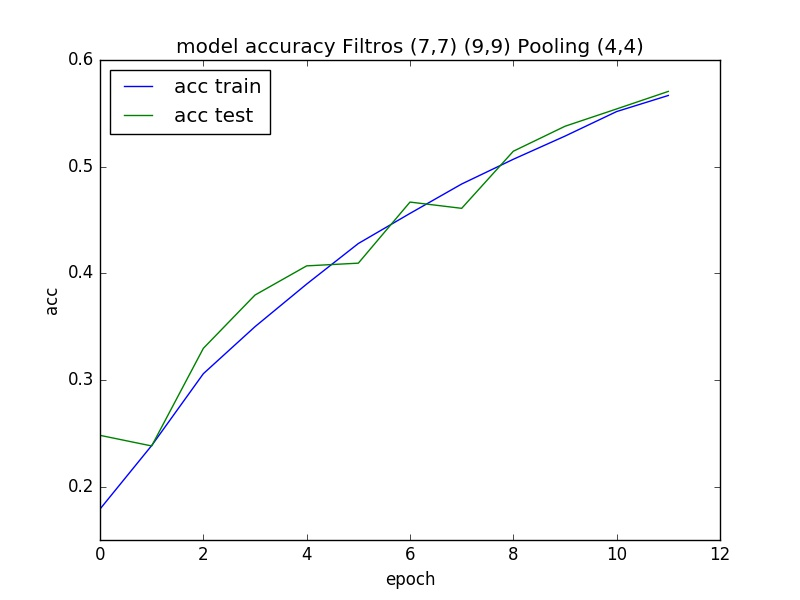
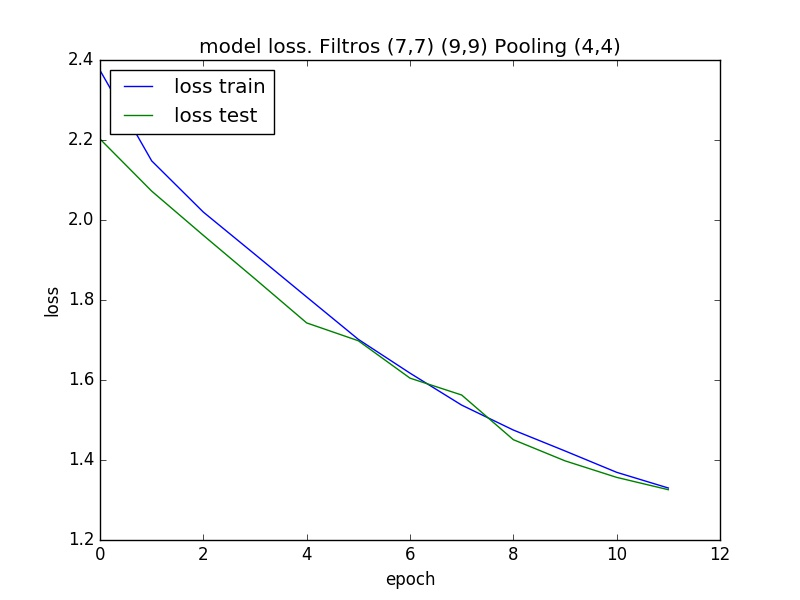

Luego, los filtros son aumentados aún más de tamaño, llegando a 9x9 en la primera capa, y 11x11 en la segunda.


In [7]:
#PARTE D MAYOR MAYOR
model = Sequential()
model.add(Conv2D(16, (9, 9), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(5, 5), data_format="channels_first"))
model.add(Conv2D(512, (11, 11), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5), data_format="channels_first"))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()
adagrad = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])
hist = model.fit(X_train, Y_train, batch_size=1280, epochs=12, verbose=1, validation_data=(X_test, Y_test))


#Se evalua el modelo sobre el conjunto de validacion
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 3, 32, 16)         41488     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 6, 3)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 6, 512)         186368    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 1, 102)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 306)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                6140      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                210       
Total para

Nuevamente se puede observar que disminuye, casi un 4% con el caso anterior, y más de un 34% con los filtros de menor tamaño.

Se puede concluir que el aumento significativo del tamaño de los filtros, incide negativamente en el desempeño final de la red, esto se puede deber, a que los filtros no estarán fijandose en porciones pequeñas de la imágenes, es decir, no podrán detectar los detalles importantes que permitan clasificar los datos, esto ya que sus dimensiones son mayores. 

Al no poder centrarse en detalles, cada uno de los filtros tendrá una visión más global de las figuras presentes en las imágenes, lo que afectarám de sobre manera en como la red obtendrá las características importante de los datos.

A continuación se puedne obserar los resultados de una red con capas convolucionales de filtros de mayor tamaño.

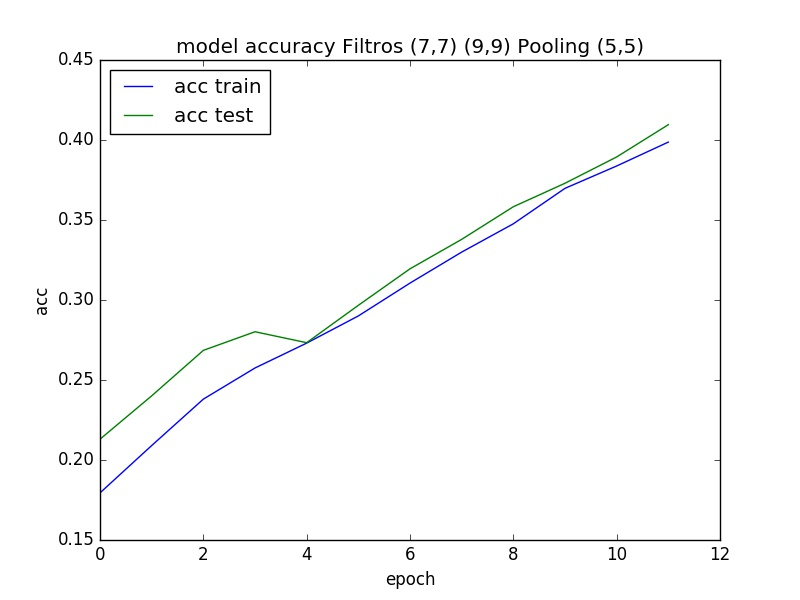
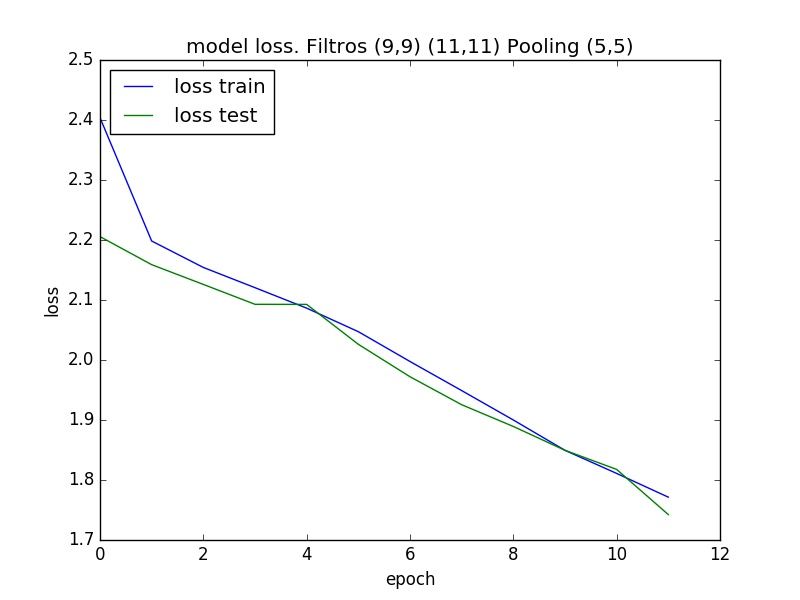


#### Cantidad de filtros

Una vez ya obtenido los resultados de acuerdo al tamaño de los filtros, se comenzará a variar la cantidad de estos, para observar en que medida afecta al desempeño de la red.

Para comenzar, se disminuirá el número de estos, en ambas capas de la red, quedando finalmente con una primera capa de 8 filtros, y una segunda capa de 256. Ambas tendrán el mismo tamaño de filtros propuestos inicialmente, 5x5 en la primera y 7x7 en la segunda.

Los resultados son los siguientes.

In [8]:
#Parte E Menor
model = Sequential()
model.add(Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
model.add(Conv2D(256, (7, 7), padding='same', activation='relu'))
model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
adagrad = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])
hist = model.fit(X_train, Y_train, batch_size=1280, epochs=12, verbose=1, validation_data=(X_test, Y_test))



#Se evalua el modelo sobre el conjunto de validacion
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 73257 samples, validate on 26032 samples
Epoch 1/12
73257/73257 [==============================] - 2s - loss: 2.3327 - acc: 0.1820 - val_loss: 2.2250 - val_acc: 0.1975
Epoch 2/12
73257/73257 [==============================] - 2s - loss: 2.2313 - acc: 0.1913 - val_loss: 2.2149 - val_acc: 0.2048
Epoch 3/12
73257/73257 [==============================] - 2s - loss: 2.2036 - acc: 0.2120 - val_loss: 2.1788 - val_acc: 0.1968
Epoch 4/12
73257/73257 [==============================] - 2s - loss: 2.1183 - acc: 0.2345 - val_loss: 2.0428 - val_acc: 0.2769
Epoch 5/12
73257/73257 [==============================] - 2s - loss: 2.0167 - acc: 0.2763 - val_loss: 1.9497 - val_acc: 0.3081
Epoch 6/12
73257/73257 [==============================] - 2s - loss: 1.9054 - acc: 0.3226 - val_loss: 1.8137 - val_acc: 0.3689
Epoch 7/12
73257/73257 [==============================] - 2s - loss: 1.7874 - acc: 0.3752 - val_loss: 1.7414 - val_acc: 0.4018
Epoch 8/12
73257/73257 [==============================] - 2s 

La red alcanzó un total de 49% de accuracy vs los datos de prueba, algo más bajo que los obtenidos variando el tamaño de filtros, pero aún así es un buen desempeño de la red. Más aún si se observa que la curva de prueba aún se mantenía con pendiente positiva, lo que nos indica que aún era posible obtener un mejor resultado.

A continuación se puede observar dicho resultado por cada epoch.

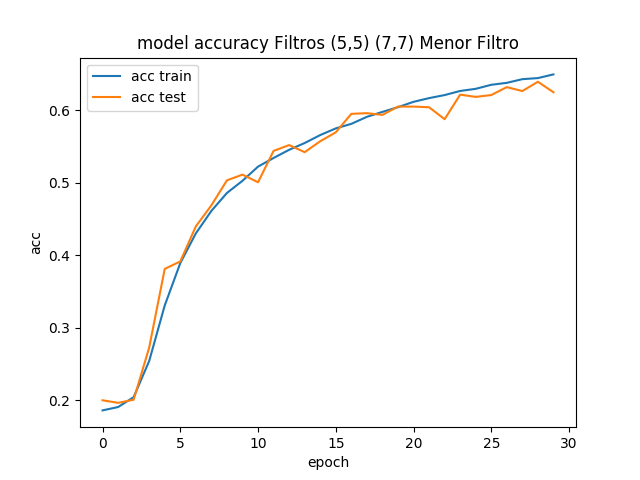
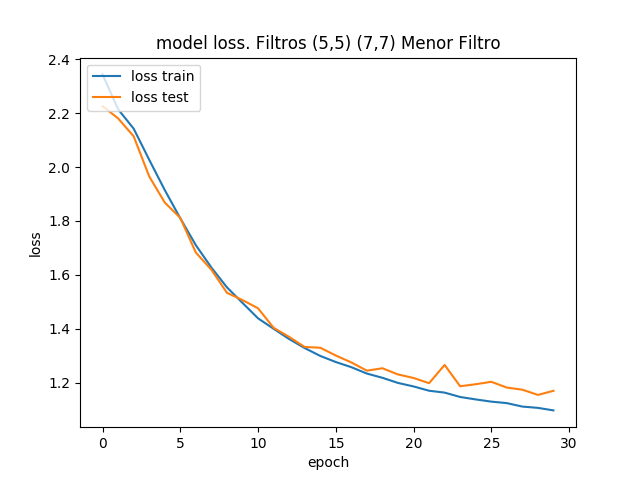

Como caso contrario, ambas cantidades de filtros son aumentadas, con respecto al número incial de estos.
En este caso ambos números son llevados al doble. Para la primera capa se usan 32 filtros, y para la segunda, 1024, ambos manteniendo el tamaño inicial de los filtros.

In [9]:
#PARTE E MAYOR
model = Sequential()
model.add(Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
model.add(Conv2D(1024, (7, 7), padding='same', activation='relu'))
model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()
adagrad = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])
hist = model.fit(X_train, Y_train, batch_size=1280, epochs=12, verbose=1, validation_data=(X_test, Y_test))



#Se evalua el modelo sobre el conjunto de validacion
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 3, 32, 32)         25632     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 16, 16)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 16, 1024)       803840    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 3, 8, 512)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                245780    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                210       
Total para

Al parecer la red comienza a tener problemas al trabajar con un número muy elevado de filtros. Esto dado que los valores de perdida y de accuracy se mantienen intactos en cada uno de los epochs, algo que no debería ocurrir. Esto puede ocurrir, ya que al tener una gran cantidad de estos, la red no pueda distinguir bien, cuales son los que realmente ayudan a la obtención de un resultado.

A continuación se muestran los gráficos obtenidos.

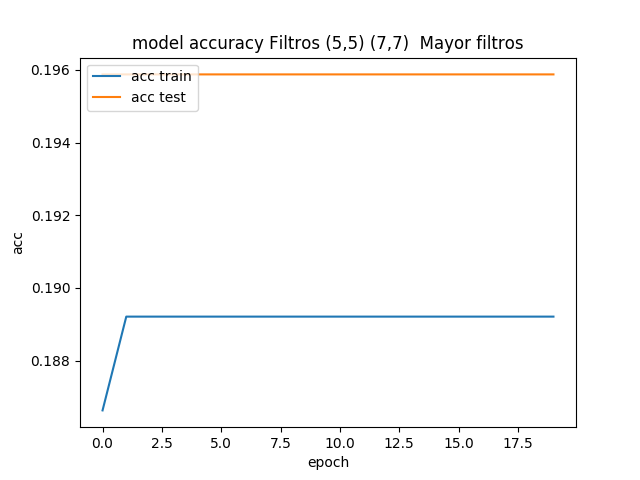
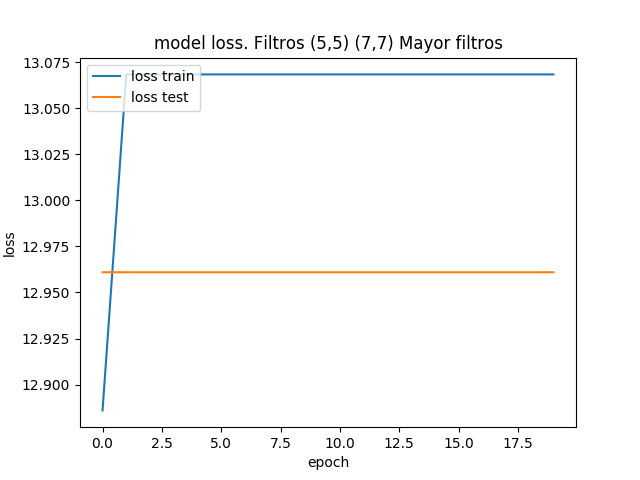

En conclusión, una menor cantidad de filtros y un menor tamaño de estos, permiten obtener los mejores resultados de la red. Esto puede ser un resultado prematuro, dado que aún así, no se estudió el efecto al variar ambos datos a la vez, quizás aumentar el tamaño de filtros y disminuir la cantidad de estos permitan obtener mejores resultados.


#### Una mejor solución

Dado los resultados obtenidos anteriormente, es que se decide implementar una mejor solución, con respecto a las utilizadas anteriormente, para ello, se toma en consideración, que:
    . Un menor tamaño de filtro, permite que la red pueda tomar en cosideración detalles más pequeños, que permiten diferenciar de mejor medida la información necesaria para que esta tome la mejor decisión.
    . Una menor cantidad de filtros, esto ya que, un menor número de estos permite, que la red no intente abarcar todos los datos de las imagenes.

In [ ]:
#Parte D CON MENOR
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()
adagrad = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])
hist = model.fit(X_train, Y_train, batch_size=1280, epochs=25, verbose=1, validation_data=(X_test, Y_test))



#Se evalua el modelo sobre el conjunto de validacion
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(CONCLUSIÓN F)

#### Uso de datos Extras!.

A continuación se hará uso de todos los datos para entrenar la red. Por simplicidad, se usarla la red "estandar", es decir, la que se utiliza como modelo en esta sección de la tarea. 2 capas convolucionales seguidas ambas por una Max-Pooling, 

In [10]:
#PARTE i Con datos extras.
train_data = sio.loadmat('data/extra_32x32.mat')
test_data = sio.loadmat('data/test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))

X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

model = Sequential()
model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
model.add(Conv2D(512, (7, 7), padding='same', activation='relu'))
model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()
adagrad = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])
hist = model.fit(X_train, Y_train, batch_size=1280, epochs=100, verbose=1, validation_data=(X_test, Y_test))


#Se evalua el modelo sobre el conjunto de validacion
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 3, 32, 16)         12816     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 3, 16, 8)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 16, 512)        201216    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 8, 256)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                122900    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                210       
Total para

La red, inicialmente fue entrenada con una cantidad de 200 epochs, los resultados pueden ser observados en los gráficos.

Es posible apreciar, la significativa ventaja que permite el uso de todos los datos de entrenamiento, que son más de 500000. Esto se debe en gran medida, a que en cada uno de los tipos de imágenes, existirán mayores cantidades de ejemplos, donde un mismo objeto, se verá representado en distintas situaciones, lo que ayudará en gran medida, a poder detallar de mejor manera, que posee ese objeto que lo distinga de los otros.

Por ejemplo un auto, quizás, al utilizar la versión pequeña de datos de entrenamiento, la red aún no haya sido capaz de detectar de buena forma la diferencia que existía entre dicha clase, y la de un camión, pero, al utilizar todos los datos, permita afinar dichos detalles, y permitir así, diferenciar cada una de las clases.

El test accuracy final es de un 88%, el mayor de todos los entrenamientos obtenidos anteriormente.

Aún así, no es posible comparar de igual medida todas las redes, esto dado que, las redes anteriormente implementadas, sólo fueron entrenadas en una pequeña cantidad de epochs, con un learning rate muy bajo, lo que no permitió que la red se entrenara de buena forma en pocos epochs. Esto produjo que las redes anteriores, no tuvieran el tiempo necesario para converger hacia un valor, todas terminaron con una pendiente de accuracy positivo, es decir, aún se encontraban en su etapa de aprendizaje.

Igualmente, si se compara con el mayor porcentaje observado anteriormente, este logra aumentar su accuracy en casi un 20%, lo que es muy significativo para este ejercicio.

Los graficos obtenidos utilizando todos los datos de entrenamiento, pueden ser observados a continuación.

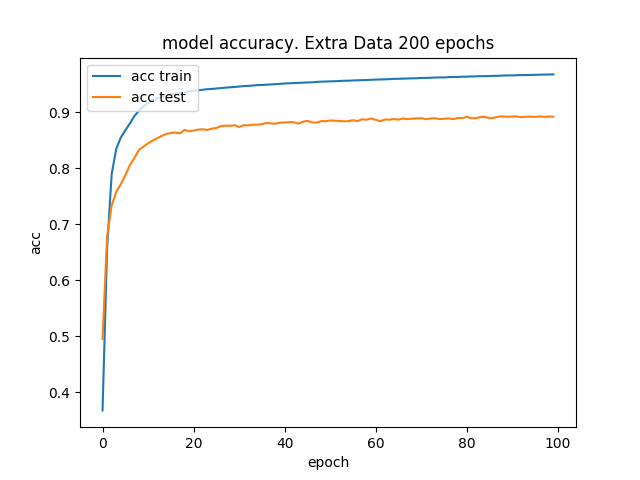
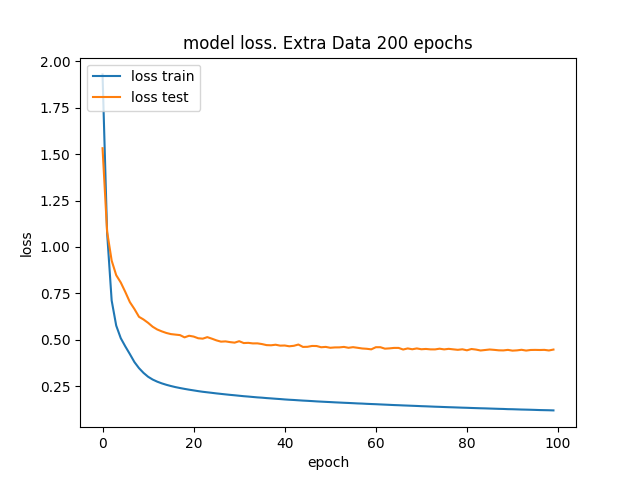